In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)
url <- "https://raw.githubusercontent.com/Xela-debug/datasets/main/Housing.csv"
housing_df <- read_csv(url)
set.seed(2023)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [6]:
housing_df

price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished
1750000,3850,3,1,2,yes,no,no,no,no,0,no,unfurnished


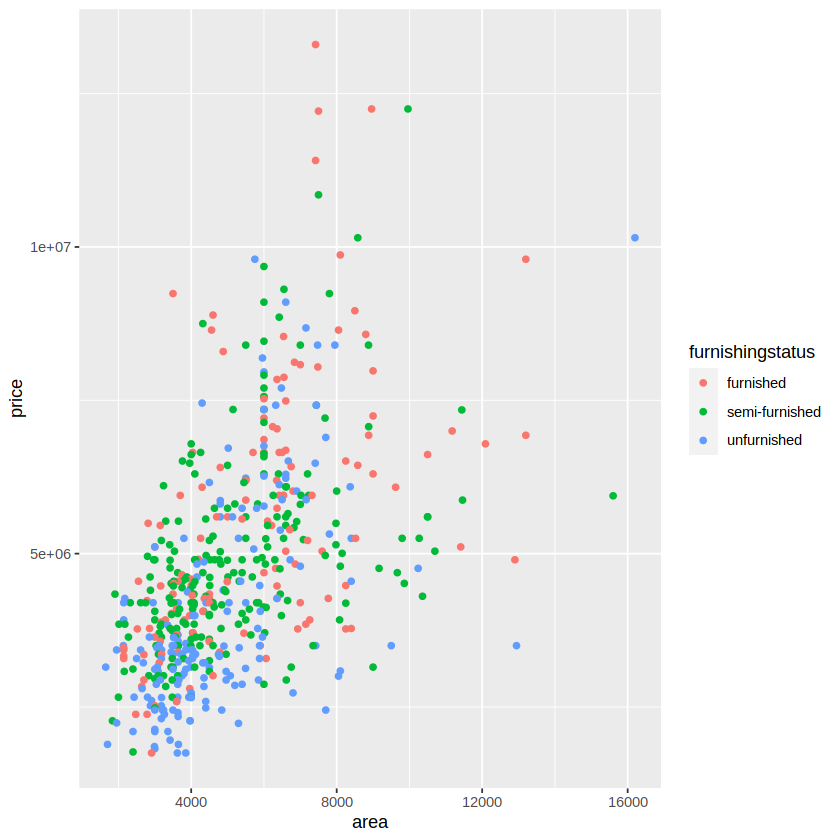

In [3]:
housing_plot <- housing_df |>
    ggplot(aes(x = area, y = price, colour = furnishingstatus)) +
        geom_point()
housing_plot

In [4]:
set.seed(2023)
housing_split <- initial_split(housing_df, prop = 0.75, strata = price)
housing_test <- testing(housing_split)
housing_train <- training(housing_split)

In [5]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

knn_recipe <- recipe(price ~ area + bedrooms + bathrooms + stories + parking, 
                     data = housing_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_vfold <- vfold_cv(housing_train, v = 5, strata = price)

gridvals <- tibble(neighbors = seq(1, 10))

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec)

knn_results <- knn_fit |>
    tune_grid(resamples = knn_vfold, grid = gridvals) |>
    collect_metrics()

knn_results

ERROR: [1m[33mError[39m in `check_installs()`:[22m
[33m![39m Some package installs are required: 
[36m•[39m 'kknn', 'kknn'


In [ ]:
knn_plot <- knn_results |>
    filter(.metric == "rmse") |>
    select(neighbors, .metric, mean) |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "Value of K", y = "Root Mean Squared Error")

knn_plot

RMSE drops to a low at a K-value of 8, but it actually is quite close to the minimum at a K-value of 5. Regardless, a K of 8 will be used as there are sufficient data points in the set to not risk problems.

In [ ]:
# Checking one more time for lowest RMSE
knn_min <- knn_results |>
   filter(.metric == "rmse") |>
   slice_min(mean, n = 1) |>
   pull(neighbors)

knn_min

In [ ]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = knn_min) |>
    set_engine("kknn") |>
    set_mode("regression")

knn_best_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_best_spec) |>
    fit(data = housing_train)

knn_summary <- knn_best_fit |>
    predict(housing_test) |>
    bind_cols(housing_test) |>
    metrics(truth = price, estimate = .pred)

knn_summary